<a href="https://colab.research.google.com/github/mnds18/Amazon_Reviews_Sentiment_Analysis/blob/master/20190606_Propensity_Model_First_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [0]:
# print_function for compatibility with Python 3
from __future__ import print_function

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

# Pickle for saving model files
import pickle

## Import data

In [0]:
# Load data from CSV
df_raw = pd.read_csv('cust_cube_all.csv', encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df_raw.head()

,MDM_ENTITY_CLUSTER_ID,COUNT_CUSTOMER,CUSTOMERID_COUNT,VISITS,QUOTES_COUNT,FIRST_VISIT,LAST_VISIT,A_TRAFFICSOURCE_SOURCE,A_DEVICE_ISMOBILE,A_DEVICE_MOBILEDEVICEBRANDING,A_DEVICE_MOBILEDEVICEMODEL,A_DEVICE_DEVICECATEGORY,A_DEVICE_BROWSER,A_DEVICE_LANGUAGE,A_GEONETWORK_COUNTRY,A_GEONETWORK_REGION,A_GEONETWORK_CITY,DAYS_LASTV,DAYS_FIRSTV,DAYS_VISITS,AGE,POLICIES,RISKS,GWP,CLV_TOTAL,VALUE_TARGET,OTHER,MOTOR,HOME,LANDLORD,LIFE,PAID_MOTOR,PAID_HOME,PAID_LANDLORD,PAID_OTHER,CC_MOTOR,CC_HOME,CC_LANDLORD,CC_OTHER,CLAIM_ACCEPT,CLAIM_NOTACCEPT,FIRST_DATE_OCC,LAST_DATE_OCC,FIRST_DATE_REP,LAST_DATE_REP,TENURE,RDA_SEG,CUSTOMER_PCODE,STATE,CUSTOMER_GENDER,CALL_VOLUME,AVG_DURATION_SECONDS,ISSUE_RESOLUTION_SCORE,AGENT_NPS,ALLIANZ_NPS,REPEAT_CALLER_SCORE
0,38,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,2.0,2.0,738.36,29.347521,-289.677023,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.167123,6. Struggling Seniors,2176.0,NSW,M,NaN,NaN,NaN,NaN,NaN,NaN
1,58,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,447.23,-114.120341,-48.539028,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.375342,NaN,2322.0,NSW,C,NaN,NaN,NaN,NaN,NaN,NaN
2,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,2.0,2.0,616.43,555.123276,85.949648,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.268493,9. Comfortable Seniors,6027.0,WA,F,NaN,NaN,NaN,NaN,NaN,NaN
3,101,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,1.0,1.0,232.32,29.837192,0.000000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.295890,6. Struggling Seniors,2835.0,NSW,F,NaN,NaN,NaN,NaN,NaN,NaN
4,115,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,2.0,2.0,1927.27,179.305450,-224.269403,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.375208,2. Affluent Families,2752.0,NSW,F,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
print(df_raw.shape)

(631427, 56)


In [0]:
# Drop duplicates
print( df_raw.shape )
df_raw = df_raw.drop_duplicates()
print( df_raw.shape )

(631427, 56)
(631427, 56)


In [0]:
numerical_feats = df_raw.dtypes[df_raw.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_raw.dtypes[df_raw.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  37
Number of Categorical features:  19


## Filling missing values

In [0]:
#List of features with missing values
total = df_raw.isnull().sum().sort_values(ascending=False)
percent = (df_raw.isnull().sum()/df_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(60)

,Total,Percent
PAID_OTHER,631069,0.999433
CC_OTHER,631069,0.999433
PAID_LANDLORD,627774,0.994215
CC_LANDLORD,627774,0.994215
LIFE,617309,0.977641
PAID_HOME,615379,0.974585
CC_HOME,615379,0.974585
A_DEVICE_MOBILEDEVICEMODEL,600100,0.950387
A_DEVICE_MOBILEDEVICEBRANDING,600100,0.950387
LANDLORD,586474,0.928807


In [0]:
# numeric columns where NaN values means zero
cols_fillna_zero = ['CLAIM_NOTACCEPT','CLAIM_ACCEPT',
                       'CC_OTHER','CC_LANDLORD','CC_HOME','CC_MOTOR',
                       'PAID_OTHER','PAID_LANDLORD','PAID_HOME','PAID_MOTOR',
                       'LIFE','LANDLORD','HOME','MOTOR','OTHER']

# numeric columns where NaN values have meaning
cols_fillna_dummy = ['REPEAT_CALLER_SCORE','ALLIANZ_NPS','AGENT_NPS','ISSUE_RESOLUTION_SCORE',
                       'AVG_DURATION_SECONDS','CALL_VOLUME','TENURE','VALUE_TARGET','CLV_TOTAL',
                       'GWP','RISKS','POLICIES','AGE','DAYS_VISITS','DAYS_FIRSTV','DAYS_LASTV',
                       'QUOTES_COUNT','VISITS','CUSTOMERID_COUNT','COUNT_CUSTOMER']


# categorical columns where NaN values have meaning
cols_fillna_NA = ['CUSTOMER_GENDER','STATE','CUSTOMER_PCODE','RDA_SEG',
                  'A_GEONETWORK_CITY','A_GEONETWORK_REGION','A_GEONETWORK_COUNTRY',
                  'A_DEVICE_LANGUAGE','A_DEVICE_BROWSER','A_DEVICE_DEVICECATEGORY',
                  'A_DEVICE_MOBILEDEVICEMODEL','A_DEVICE_MOBILEDEVICEBRANDING',
                  'A_DEVICE_ISMOBILE','A_TRAFFICSOURCE_SOURCE']

# replace 'NaN' with 0 in these columns
for col in cols_fillna_zero:
    df_raw[col].fillna(0,inplace=True)

# replace 'NaN' with - 9999 in these columns
for col in cols_fillna_dummy:
    df_raw[col].fillna(-9999,inplace=True)
    
    
# replace 'NaN' with 'NA'in these columns
for col in cols_fillna_NA:
    df_raw[col].fillna('NA',inplace=True)    

In [9]:
#List of features with missing values
total = df_raw.isnull().sum().sort_values(ascending=False)
percent = (df_raw.isnull().sum()/df_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(60)

,Total,Percent
FIRST_DATE_OCC,558232,0.884080
LAST_DATE_OCC,558232,0.884080
FIRST_DATE_REP,558232,0.884080
LAST_DATE_REP,558232,0.884080
FIRST_VISIT,548366,0.868455
LAST_VISIT,548366,0.868455
REPEAT_CALLER_SCORE,0,0.000000
DAYS_LASTV,0,0.000000
A_GEONETWORK_REGION,0,0.000000
A_GEONETWORK_CITY,0,0.000000


In [0]:
df.head()

### Creating the target variables

In [0]:
df_raw['motor_flag'] = (df_raw.MOTOR > 0).astype(int)
df_raw['home_flag'] = (df_raw.HOME > 0).astype(int)
df_raw['landlord_flag'] = (df_raw.LANDLORD > 0).astype(int)
df_raw['other_flag'] = (df_raw.OTHER > 0).astype(int)

In [0]:
print(df_raw.motor_flag.mean())
print("*"*100)
print(df_raw.home_flag.mean())
print("*"*100)
print(df_raw.landlord_flag.mean())
print("*"*100)
print(df_raw.other_flag.mean())
print("*"*100)

0.4962268005644358
****************************************************************************************************
0.2564429458987341
****************************************************************************************************
0.07119271111308195
****************************************************************************************************
0.2759701438171
****************************************************************************************************


In [0]:
# Class distributions for 'motor_flag'
sns.countplot(y='motor_flag', data=df_raw)

In [0]:
# Class distributions for 'home_flag'
sns.countplot(y='home_flag', data=df_raw)

In [0]:
# Class distributions for 'landlord_flag'
sns.countplot(y='landlord_flag', data=df_raw)

In [0]:
# Class distributions for 'other_flag'
sns.countplot(y='other_flag', data=df_raw)

### Dropping columns which would not be used later, or ID columns

In [0]:
df_raw.head()

,MDM_ENTITY_CLUSTER_ID,COUNT_CUSTOMER,CUSTOMERID_COUNT,VISITS,QUOTES_COUNT,FIRST_VISIT,LAST_VISIT,A_TRAFFICSOURCE_SOURCE,A_DEVICE_ISMOBILE,A_DEVICE_MOBILEDEVICEBRANDING,A_DEVICE_MOBILEDEVICEMODEL,A_DEVICE_DEVICECATEGORY,A_DEVICE_BROWSER,A_DEVICE_LANGUAGE,A_GEONETWORK_COUNTRY,A_GEONETWORK_REGION,A_GEONETWORK_CITY,DAYS_LASTV,DAYS_FIRSTV,DAYS_VISITS,AGE,POLICIES,RISKS,GWP,CLV_TOTAL,VALUE_TARGET,OTHER,MOTOR,HOME,LANDLORD,LIFE,PAID_MOTOR,PAID_HOME,PAID_LANDLORD,PAID_OTHER,CC_MOTOR,CC_HOME,CC_LANDLORD,CC_OTHER,CLAIM_ACCEPT,CLAIM_NOTACCEPT,FIRST_DATE_OCC,LAST_DATE_OCC,FIRST_DATE_REP,LAST_DATE_REP,TENURE,RDA_SEG,CUSTOMER_PCODE,STATE,CUSTOMER_GENDER,CALL_VOLUME,AVG_DURATION_SECONDS,ISSUE_RESOLUTION_SCORE,AGENT_NPS,ALLIANZ_NPS,REPEAT_CALLER_SCORE,motor_flag,home_flag,landlord_flag,other_flag
0,38,1,-9999.0,-9999.0,-9999.0,NaN,NaN,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-9999.0,-9999.0,-9999.0,80.0,2.0,2.0,738.36,29.347521,-289.677023,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.167123,6. Struggling Seniors,2176,NSW,M,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,1
1,58,1,-9999.0,-9999.0,-9999.0,NaN,NaN,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-9999.0,-9999.0,-9999.0,-9999.0,1.0,1.0,447.23,-114.120341,-48.539028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3.375342,NA,2322,NSW,C,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,0,0,1
2,99,1,-9999.0,-9999.0,-9999.0,NaN,NaN,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-9999.0,-9999.0,-9999.0,63.0,2.0,2.0,616.43,555.123276,85.949648,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,10.268493,9. Comfortable Seniors,6027,WA,F,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,0
3,101,1,-9999.0,-9999.0,-9999.0,NaN,NaN,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-9999.0,-9999.0,-9999.0,70.0,1.0,1.0,232.32,29.837192,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,13.295890,6. Struggling Seniors,2835,NSW,F,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,0
4,115,1,-9999.0,-9999.0,-9999.0,NaN,NaN,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-9999.0,-9999.0,-9999.0,61.0,2.0,2.0,1927.27,179.305450,-224.269403,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,14.375208,2. Affluent Families,2752,NSW,F,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,1,0,0


In [0]:
## dropping columns which would not be used later

print(df_raw.shape)

drop_col = ['FIRST_DATE_OCC', 'LAST_DATE_OCC','FIRST_DATE_REP','LAST_DATE_REP', 
            'FIRST_VISIT','LAST_VISIT','MDM_ENTITY_CLUSTER_ID','COUNT_CUSTOMER'
               ,'home_flag','landlord_flag','other_flag'
           ,'A_TRAFFICSOURCE_SOURCE', 'A_DEVICE_ISMOBILE',
       'A_DEVICE_MOBILEDEVICEBRANDING', 'A_DEVICE_MOBILEDEVICEMODEL',
       'A_DEVICE_DEVICECATEGORY', 'A_DEVICE_BROWSER', 'A_DEVICE_LANGUAGE',
       'A_GEONETWORK_COUNTRY', 'A_GEONETWORK_REGION', 'A_GEONETWORK_CITY',
       'CUSTOMER_PCODE']

df = pd.DataFrame(df_raw.drop(drop_col,axis=1))

print(df.shape)

(631427, 60)
(631427, 38)


### convert numeric variables with categorical values to numeric values

In [0]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  35
Number of Categorical features:  3


In [0]:
print(df[numerical_feats].columns)
print("*"*100)
print(df[categorical_feats].columns)

Index(['CUSTOMERID_COUNT', 'VISITS', 'QUOTES_COUNT', 'DAYS_LASTV',
       'DAYS_FIRSTV', 'DAYS_VISITS', 'AGE', 'POLICIES', 'RISKS', 'GWP',
       'CLV_TOTAL', 'VALUE_TARGET', 'OTHER', 'MOTOR', 'HOME', 'LANDLORD',
       'LIFE', 'PAID_MOTOR', 'PAID_HOME', 'PAID_LANDLORD', 'PAID_OTHER',
       'CC_MOTOR', 'CC_HOME', 'CC_LANDLORD', 'CC_OTHER', 'CLAIM_ACCEPT',
       'CLAIM_NOTACCEPT', 'TENURE', 'CALL_VOLUME', 'AVG_DURATION_SECONDS',
       'ISSUE_RESOLUTION_SCORE', 'AGENT_NPS', 'ALLIANZ_NPS',
       'REPEAT_CALLER_SCORE', 'motor_flag'],
      dtype='object')
****************************************************************************************************
Index(['RDA_SEG', 'STATE', 'CUSTOMER_GENDER'], dtype='object')


In [0]:
# Display first 10 rows
df.head(10) 

,CUSTOMERID_COUNT,VISITS,QUOTES_COUNT,DAYS_LASTV,DAYS_FIRSTV,DAYS_VISITS,AGE,POLICIES,RISKS,GWP,CLV_TOTAL,VALUE_TARGET,OTHER,MOTOR,HOME,LANDLORD,LIFE,PAID_MOTOR,PAID_HOME,PAID_LANDLORD,PAID_OTHER,CC_MOTOR,CC_HOME,CC_LANDLORD,CC_OTHER,CLAIM_ACCEPT,CLAIM_NOTACCEPT,TENURE,RDA_SEG,STATE,CUSTOMER_GENDER,CALL_VOLUME,AVG_DURATION_SECONDS,ISSUE_RESOLUTION_SCORE,AGENT_NPS,ALLIANZ_NPS,REPEAT_CALLER_SCORE,motor_flag
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,80.0,2.0,2.0,738.36,29.347521,-289.677023,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167123,6. Struggling Seniors,NSW,M,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.0,1.0,447.23,-114.120341,-48.539028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.375342,NA,NSW,C,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,63.0,2.0,2.0,616.43,555.123276,85.949648,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.268493,9. Comfortable Seniors,WA,F,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,70.0,1.0,1.0,232.32,29.837192,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.295890,6. Struggling Seniors,NSW,F,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,61.0,2.0,2.0,1927.27,179.305450,-224.269403,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.375208,2. Affluent Families,NSW,F,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1
5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,39.0,1.0,4.0,4731.78,-2031.920606,-779.756326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331507,1. Middled Aged Mid-Status Families,NSW,M,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0
6,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,44.0,1.0,2.0,1959.74,1957.005852,244.451289,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.009088,2. Affluent Families,NSW,F,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0
7,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,63.0,1.0,1.0,736.42,-207.702476,138.368155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.947945,9. Comfortable Seniors,QLD,F,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0
8,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,31.0,1.0,1.0,359.86,-32.742623,-97.685792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.287671,5. Struggling Families,NSW,M,1.0,321.25,-9999.0,8.0,-9999.0,-9999.0,0
9,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,72.0,1.0,1.0,864.37,819.154945,81.568427,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.150685,10. Affluent Seniors,NSW,M,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1


In [0]:
# convert_to_numeric = ['CUSTOMERID_COUNT', 'VISITS', 'QUOTES_COUNT',
#        'DAYS_LASTV', 'DAYS_FIRSTV',
#        'DAYS_VISITS', 'AGE', 'POLICIES', 'RISKS', 'GWP', 'CLV_TOTAL',
#        'VALUE_TARGET',  'TENURE', 
#          'CALL_VOLUME', 'AVG_DURATION_SECONDS',
#        'ISSUE_RESOLUTION_SCORE', 'AGENT_NPS', 'ALLIANZ_NPS',
#        'REPEAT_CALLER_SCORE']

# df[convert_to_numeric] = df[convert_to_numeric].astype(int)

In [0]:
# numerical_feats = df.dtypes[df.dtypes != "object"].index
# print("Number of Numerical features: ", len(numerical_feats))

# categorical_feats = df.dtypes[df.dtypes == "object"].index
# print("Number of Categorical features: ", len(categorical_feats))

In [0]:
# print(df[numerical_feats].columns)
# print("*"*100)
# print(df[categorical_feats].columns)

### Univariate Analysis

In [0]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  35
Number of Categorical features:  3


In [0]:
# Summarize numerical features
df.describe()

,CUSTOMERID_COUNT,VISITS,QUOTES_COUNT,DAYS_LASTV,DAYS_FIRSTV,DAYS_VISITS,AGE,POLICIES,RISKS,GWP,CLV_TOTAL,VALUE_TARGET,OTHER,MOTOR,HOME,LANDLORD,LIFE,PAID_MOTOR,PAID_HOME,PAID_LANDLORD,PAID_OTHER,CC_MOTOR,CC_HOME,CC_LANDLORD,CC_OTHER,CLAIM_ACCEPT,CLAIM_NOTACCEPT,TENURE,CALL_VOLUME,AVG_DURATION_SECONDS,ISSUE_RESOLUTION_SCORE,AGENT_NPS,ALLIANZ_NPS,REPEAT_CALLER_SCORE,motor_flag
count,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,6.314270e+05,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000,631427.000000
mean,-8683.541906,-8683.503919,-8683.541263,-8668.101779,-8667.608317,-8683.189108,-1028.825422,-1.971279,-1.800653,855.332786,357.358755,-41.604278,0.294183,0.554154,0.261788,0.085310,0.022533,326.121955,1.675958e+02,39.819019,3.136561,0.105562,0.034937,0.007879,0.000603,0.146150,0.002860,3.009625,-8953.352970,-8910.953259,-9028.733819,-9002.931303,-9008.182499,-9054.913355,0.496227
std,3379.979326,3380.076943,3379.980978,3419.714928,3420.983793,3380.891340,3107.629624,178.394212,178.398746,1062.928836,1860.291009,631.369001,0.675171,0.624039,0.452339,0.348817,0.149621,2188.354772,3.981832e+03,1444.360592,216.464461,0.374138,0.243808,0.116118,0.026119,0.459552,0.057434,144.192040,3059.970678,3196.059489,2959.948492,2996.009268,2988.910299,2923.998507,0.499986
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-10560.130000,-602447.229700,-18870.619290,0.000000,0.000000,0.000000,0.000000,0.000000,-3263.500000,-1.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000
25%,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,31.000000,1.000000,1.000000,410.705000,17.822753,-105.085146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.131507,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000
50%,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,44.000000,1.000000,1.000000,676.860000,201.127883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.216738,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000
75%,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,57.000000,1.000000,1.000000,1098.480000,599.743465,87.013705,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.126574,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,1.000000
max,59.000000,59.000000,59.000000,233.000000,233.000000,204.000000,169.000000,332.000000,335.000000,191604.130000,81701.538674,14529.979285,282.000000,33.000000,14.000000,20.000000,3.000000,227141.990000,1.236495e+06,459654.050000,66401.000000,17.000000,9.000000,7.000000,3.000000,21.000000,3.000000,118.326027,126.000000,119023.380000,2.000000,9.000000,9.000000,2.000000,1.000000


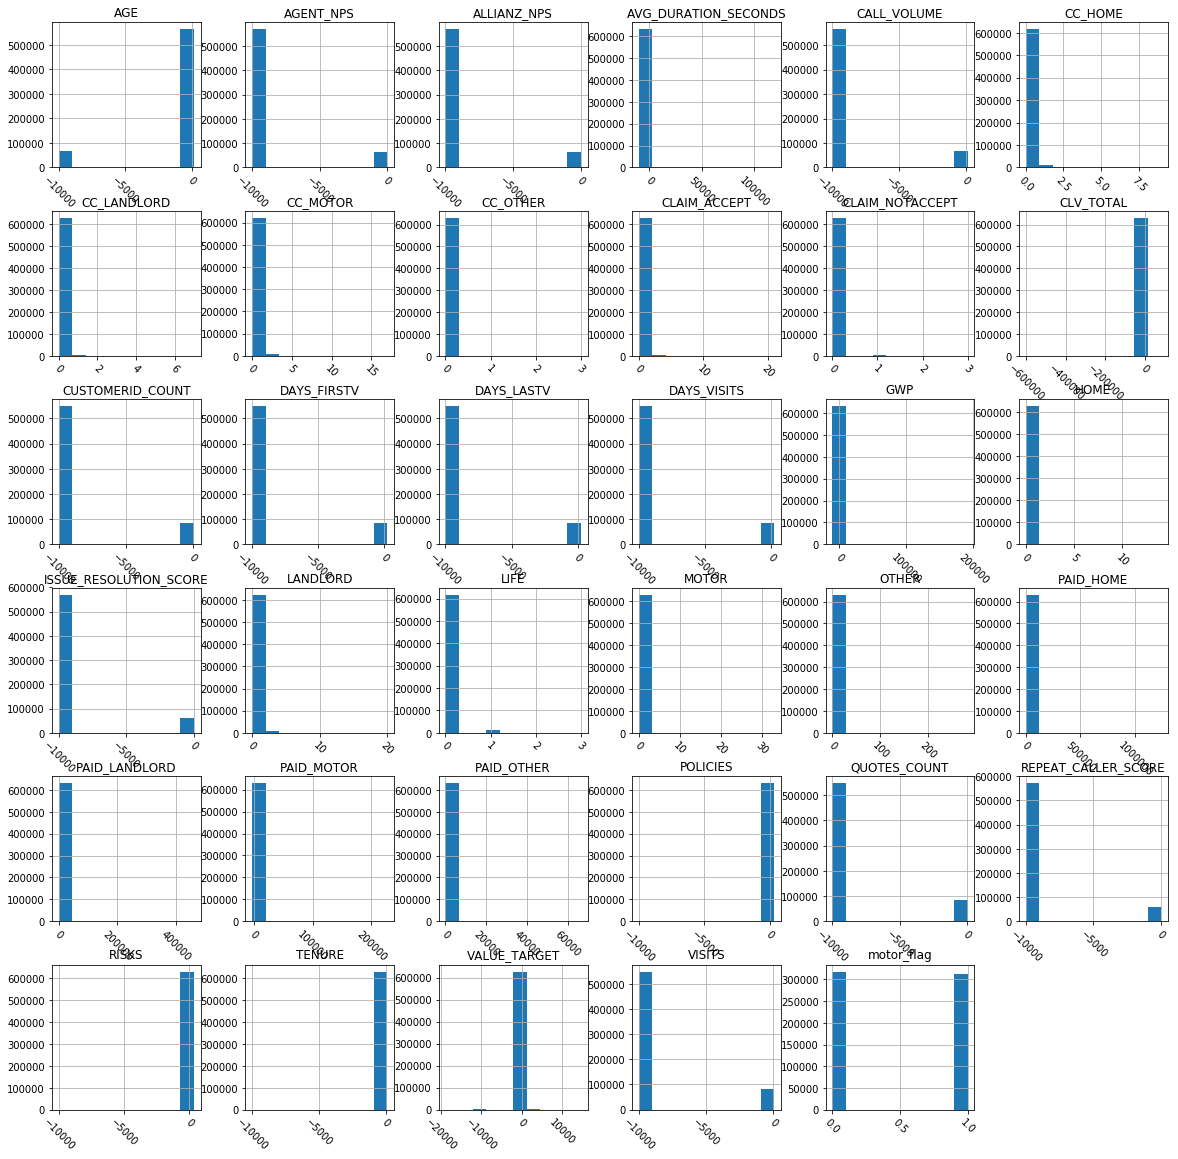

In [0]:
# Plot histogram grid
df.hist(figsize=(20,20), xrot=-45)

# Clear the text "residue"
plt.show()

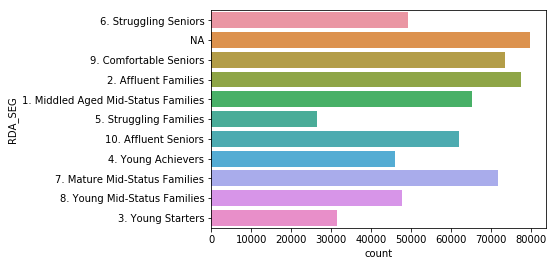

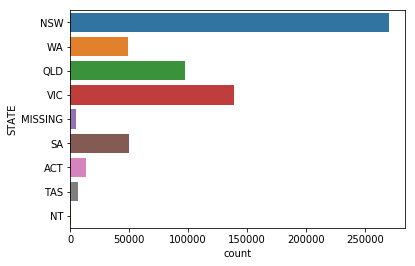

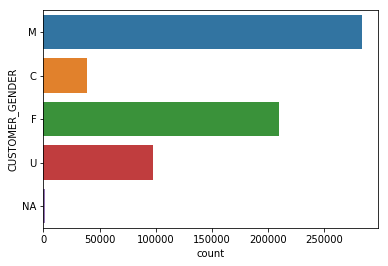

In [0]:
# Plot bar plot for each categorical feature
for feature in df.dtypes[df.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df)
    plt.show()

### Bivariate Analysis of Major Predictors

In [0]:
g = sns.FacetGrid(df, col='sales_hl')
g.map(plt.hist, 'store', bins=10)

### Converting categorical variables to dummy values

In [0]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  35
Number of Categorical features:  3


In [0]:
print(df[numerical_feats].columns)
print("*"*100)
print(df[categorical_feats].columns)

Index(['CUSTOMERID_COUNT', 'VISITS', 'QUOTES_COUNT', 'DAYS_LASTV',
       'DAYS_FIRSTV', 'DAYS_VISITS', 'AGE', 'POLICIES', 'RISKS', 'GWP',
       'CLV_TOTAL', 'VALUE_TARGET', 'OTHER', 'MOTOR', 'HOME', 'LANDLORD',
       'LIFE', 'PAID_MOTOR', 'PAID_HOME', 'PAID_LANDLORD', 'PAID_OTHER',
       'CC_MOTOR', 'CC_HOME', 'CC_LANDLORD', 'CC_OTHER', 'CLAIM_ACCEPT',
       'CLAIM_NOTACCEPT', 'TENURE', 'CALL_VOLUME', 'AVG_DURATION_SECONDS',
       'ISSUE_RESOLUTION_SCORE', 'AGENT_NPS', 'ALLIANZ_NPS',
       'REPEAT_CALLER_SCORE', 'motor_flag'],
      dtype='object')
****************************************************************************************************
Index(['RDA_SEG', 'STATE', 'CUSTOMER_GENDER'], dtype='object')


In [0]:
categoricals = ['RDA_SEG', 'STATE', 'CUSTOMER_GENDER']

# Create new dataframe with dummy features, for categoricals
df_new = pd.get_dummies(df, columns=categoricals)

# Display first 10 rows
df_new.head(10) 

,CUSTOMERID_COUNT,VISITS,QUOTES_COUNT,DAYS_LASTV,DAYS_FIRSTV,DAYS_VISITS,AGE,POLICIES,RISKS,GWP,CLV_TOTAL,VALUE_TARGET,OTHER,MOTOR,HOME,LANDLORD,LIFE,PAID_MOTOR,PAID_HOME,PAID_LANDLORD,PAID_OTHER,CC_MOTOR,CC_HOME,CC_LANDLORD,CC_OTHER,CLAIM_ACCEPT,CLAIM_NOTACCEPT,TENURE,CALL_VOLUME,AVG_DURATION_SECONDS,ISSUE_RESOLUTION_SCORE,AGENT_NPS,ALLIANZ_NPS,REPEAT_CALLER_SCORE,motor_flag,RDA_SEG_1. Middled Aged Mid-Status Families,RDA_SEG_10. Affluent Seniors,RDA_SEG_2. Affluent Families,RDA_SEG_3. Young Starters,RDA_SEG_4. Young Achievers,RDA_SEG_5. Struggling Families,RDA_SEG_6. Struggling Seniors,RDA_SEG_7. Mature Mid-Status Families,RDA_SEG_8. Young Mid-Status Families,RDA_SEG_9. Comfortable Seniors,RDA_SEG_NA,STATE_ACT,STATE_MISSING,STATE_NSW,STATE_NT,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC,STATE_WA,CUSTOMER_GENDER_C,CUSTOMER_GENDER_F,CUSTOMER_GENDER_M,CUSTOMER_GENDER_NA,CUSTOMER_GENDER_U
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,80.0,2.0,2.0,738.36,29.347521,-289.677023,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167123,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.0,1.0,447.23,-114.120341,-48.539028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.375342,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,63.0,2.0,2.0,616.43,555.123276,85.949648,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.268493,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,70.0,1.0,1.0,232.32,29.837192,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.295890,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,61.0,2.0,2.0,1927.27,179.305450,-224.269403,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.375208,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,39.0,1.0,4.0,4731.78,-2031.920606,-779.756326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331507,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
6,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,44.0,1.0,2.0,1959.74,1957.005852,244.451289,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.009088,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
7,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,63.0,1.0,1.0,736.42,-207.702476,138.368155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.947945,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
8,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,31.0,1.0,1.0,359.86,-32.742623,-97.685792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.287671,1.0,321.25,-9999.0,8.0,-9999.0,-9999.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
9,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,72.0,1.0,1.0,864.37,819.154945,81.568427,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.150685,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
print(df.shape)
print(df_new.shape)

(631427, 38)
(631427, 60)


In [0]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  35
Number of Categorical features:  3


In [0]:
numerical_feats = df_new.dtypes[df_new.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_new.dtypes[df_new.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  60
Number of Categorical features:  0


In [0]:
# Export data to csv file
df.to_csv('data_clean.csv', index=None)

In [0]:
# Export new data to csv file
df_new.to_csv('data_clean_new.csv', index=None)

### Correlations among variables

In [0]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

### look at correlation for clean data set

Number of Numerical features:  60
Number of correlation features:  9


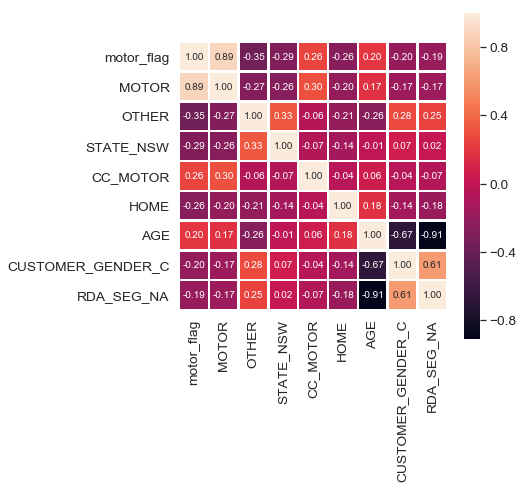

In [0]:
# only columns with correlation above this threshold value are used for the classification
min_val_corr = 0.18

corr = df_new.corr()
corr_abs = corr.abs()

# target used for correlation 
target = 'motor_flag'

numerical_feats = df_new.dtypes[df_new.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

nr_feats = len(cols_abv_corr_limit)
print("Number of correlation features: ", nr_feats)

plot_corr_matrix(df_new, nr_feats, target)

## Trying out PCA

In [0]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn (added later)
from sklearn.decomposition import PCA

In [0]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform df_final
data_scaled = scaler.fit_transform(df_new.drop(['motor_flag'],axis=1))

# Display first 5 rows of data_scaled
data_scaled[:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-3.89191474e-01, -3.89191473e-01, -3.89191474e-01,
        -3.89184275e-01, -3.89184170e-01, -3.89190838e-01,
         3.56807739e-01,  2.22612742e-02,  2.13042761e-02,
        -1.10047704e-01, -1.76322679e-01, -3.92912769e-01,
         1.04539137e+00,  7.14452040e-01, -5.78743325e-01,
        -2.44569646e-01, -1.50601134e-01, -1.49026208e-01,
        -4.20901561e-02, -2.75686356e-02, -1.44899700e-02,
        -2.82148417e-01, -1.43296501e-01, -6.78531065e-02,
        -2.31015236e-02, -3.18026909e-01, -4.97999367e-02,
        -1.97133196e-02, -3.41718261e-01, -3.40434089e-01,
        -3.27798592e-01, -3.32465422e-01, -3.31498167e-01,
        -3.22875470e-01, -3.39972954e-01, -3.30470250e-01,
        -3.74205160e-01, -2.28790317e-01, -2.80338839e-01,
        -2.09597686e-01,  3.43315921e+00, -3.58015020e-01,
        -2.85993470e-01, -3.63032279e-01, -3.80629501e-01,
        -1.47163529e-01, -8.58340001e-02,  1.15492672e+00,
        -3.97076078e-02, -4.27268407e-01, -2.93147662e-0

In [0]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
# Generate new features
PC_items = pca.transform(data_scaled)

# Display first 5 rows
PC_items[:5]

array([[-1.06233542e+00, -6.90025868e-01,  1.81972073e-01,
        -3.99951454e-02, -9.25878141e-01,  9.53016698e-01,
         1.60927548e+00, -9.42796597e-01,  8.81910334e-02,
        -4.25074996e-01, -4.44748593e-02,  1.16285757e+00,
         2.32279019e-01,  5.57263096e-01,  1.14909366e+00,
         1.86903227e-01, -6.30899974e-01, -1.55121626e+00,
         9.20101603e-02, -4.56078162e-01,  2.43564581e-02,
         1.86954682e-01,  1.68383105e+00, -5.66165920e-01,
         4.50374572e-03,  7.41137488e-01, -3.15690944e-01,
         2.08881261e-01, -6.51865971e-01,  1.20809997e+00,
        -2.87841819e-01, -1.05906139e+00, -5.35752775e-02,
         4.99255516e-01, -1.36009607e-01,  5.52650476e-01,
         2.54278770e-01,  5.23850658e-02, -2.91818782e-01,
        -1.80296469e-01,  3.14761983e-02,  7.64402755e-02,
         1.85435531e-01, -7.33422627e-03, -4.06543941e-02,
        -1.52355116e-02, -3.47825385e-03, -1.37918963e-03,
         1.86594519e-03,  6.44016244e-05,  7.41019653e-0

In [0]:
# Sum of explained variance ratio
pca.explained_variance_ratio_.sum()

1.0

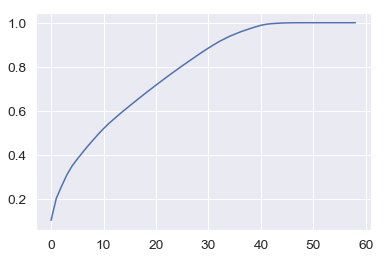

In [0]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [0]:
# How much variance we'd capture with the first 30 components
cumulative_explained_variance[30]

0.8853934050700666

In [0]:
# Initialize PCA transformation, only keeping 30 components
pca = PCA(n_components=30)

# Fit and transform data_scaled
PC_items = pca.fit_transform(data_scaled)

# Display shape of PC_items
PC_items.shape

(631427, 30)

In [0]:
# Put PC_items into a dataframe
PCA_data = pd.DataFrame(PC_items)

# Name the columns
PCA_data.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
PCA_data.index = df_new.index
print( all( df.index == PCA_data.index) )

# Display first 5 rows
PCA_data.head()

True


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-1.062336,-0.690026,0.181970,-0.039990,-0.925863,0.953051,1.609239,-0.942822,0.088317,-0.425116,-0.044457,1.162810,0.232433,0.557536,1.149117,0.187335,-0.638654,-1.552613,0.075937,-0.448069,0.024190,0.188145,1.684419,-0.566859,0.005928,0.736986,-0.287376,0.200141,-0.656204,1.213975
1,-1.386284,-1.204665,2.936615,4.515569,1.631457,1.026009,-0.403860,0.031868,-0.029555,-0.088556,-0.254951,0.273244,-0.408019,-0.188457,-0.067043,0.113927,-0.092155,-0.042046,-0.134815,0.071428,-0.158195,0.091023,-0.033126,0.124058,0.166587,0.144716,0.116654,0.006914,-0.019561,-0.039426
2,-1.134427,-0.327908,-0.687838,-1.002322,-0.178373,-0.890372,-1.699345,-0.966068,0.191936,0.367380,0.341978,1.408760,-0.212064,-1.271964,-1.802054,-0.853416,1.133292,2.262408,-0.300991,-0.086166,0.829210,-1.201915,1.931244,-0.577954,0.735712,-0.027515,0.224159,-0.429418,0.450747,1.377079
3,-1.063435,-0.626361,-0.032949,-0.426938,-1.016403,0.635458,-0.623589,-0.982139,-0.132584,1.521546,0.035624,1.353957,0.029636,0.259759,1.129193,0.206160,-0.727327,-1.540005,0.162293,-0.435341,-0.021059,0.142525,1.713491,-0.607602,-0.080235,0.731704,-0.375421,0.265733,-0.683423,1.130307
4,-1.042188,-0.437810,-0.598978,-0.537172,-0.563806,0.021766,-0.083745,0.515570,-0.486440,1.988581,-0.678858,-0.315614,-0.340655,-1.525324,0.332530,-0.416802,-1.128202,-0.299590,-1.264577,0.335674,0.424772,0.346946,-0.064836,-0.473446,0.130715,0.146002,0.334801,-0.276041,0.156318,0.460351


In [0]:
# Save pca_item_data.csv
PCA_data.to_csv('pca_data.csv')

# Modeling

In [0]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# X_train,X_test,y_train,y_test = StratifiedShuffleSplit(df.drop('readmitted',axis=1),
#                                                  df['readmitted'],
#                                                  test_size=0.2,
#                                                  random_state=2)

X_train,X_test,y_train,y_test = train_test_split(df_new.drop('motor_flag',axis=1),
                                                 df_new['motor_flag'],
                                                 test_size=0.2,
                                                 random_state=2)

In [0]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((505141, 59), (126286, 59), (505141,), (126286,))

In [0]:
# Normalize can be set to True to print proportions instead of number 
y_train.value_counts(normalize=True)

0    0.503788
1    0.496212
Name: motor_flag, dtype: float64

In [0]:
y_test.value_counts(normalize=True)

0    0.503714
1    0.496286
Name: motor_flag, dtype: float64

In [0]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [0]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split # Scikit-Learn 0.18+

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# For standardization
from sklearn.preprocessing import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

In [0]:
# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=123)),
    'dt' : make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    'xgb' : make_pipeline(StandardScaler(), XGBClassifier(random_state=123))
}

In [0]:
# List tuneable hyperparameters of our dt pipeline
pipelines['dt'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=123,
               splitter='best'))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=123,
             splitter='best'),
 'standardscaler__copy': True,
 '

In [0]:
# List tuneable hyperparameters of our gb pipeline
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('gradientboostingclassifier',
   GradientBoostingClassifier(criterion='friedman_mse', init=None,
                 learning_rate=0.1, loss='deviance', max_depth=3,
                 max_features=None, max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=1, min_samples_split=2,
                 min_weight_fraction_leaf=0.0, n_estimators=100,
                 n_iter_no_change=None, presort='auto', random_state=123,
                 subsample=1.0, tol=0.0001, validation_fraction=0.1,
                 verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'gradientboostingclassifier': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes

In [0]:
# List tuneable hyperparameters of our xgb pipeline
pipelines['xgb'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
          max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
          n_estimators=100, n_jobs=1, nthread=None,
          objective='binary:logistic', random_state=123, reg_alpha=0,
          reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
          subsample=1, verbosity=1))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=123,

In [0]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

In [0]:
# Decision Tree hyperparameters
dt_hyperparameters = {
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 0.33]
}


In [0]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}


In [0]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [0]:
# Gradient Boosted Tree hyperparameters
xgb_hyperparameters = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],
    'xgbclassifier__max_depth': [1, 3, 5]
}

In [0]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'dt' : dt_hyperparameters,    
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'xgb' : xgb_hyperparameters
}

### run this code to check that hyperparameters is set up correctly

In [0]:
for key in ['l1', 'l2', 'dt', 'rf', 'gb','xgb']:    
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

l1 was found in hyperparameters, and it is a grid.
l2 was found in hyperparameters, and it is a grid.
dt was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
xgb was found in hyperparameters, and it is a grid.


### Fit and tune models with cross-validation

In [0]:
from time import sleep
import time
from datetime import datetime
import time

# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
#     t0=time()
    # Fit model on X_train, y_train
    print(datetime.now().time())
    ts = time.time()
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')
    print("training time: {0:.3f}".format(time.time()-ts))
#     print "training time:", round(time()-t0, 3), "s" # the time would be round to 3 decimal in seconds

16:10:42.337000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


l1 has been fitted
training time: 456.695
16:18:19.033000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


l2 has been fitted
training time: 844.799
16:32:23.833000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


dt has been fitted
training time: 48.883
16:33:12.717000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted
training time: 2691.154
17:18:03.871000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted
training time: 4382.085
18:31:05.956000


## Model Selection based on performance

In [0]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )